In [1]:
import os
import pandas as pd

# Đường dẫn tới thư mục gốc của dataset
base_folder = '/kaggle/input/dataset-car/Data'

# Ánh xạ giữa tên hãng xe và CategoryID
category_mapping = {
    'Honda': 0,
    'Hyundai': 1,
    'KIA': 2,
    'Mazda': 3,
    'Mitsubishi': 4,
    'Others': 5,
    'Suzuki': 6,
    'Toyota': 7
}

# Danh sách để lưu thông tin ảnh
data = []

# Quét qua từng thư mục con trong thư mục gốc
for category_name, category_id in category_mapping.items():
    category_folder = os.path.join(base_folder, category_name)
    
    # Kiểm tra nếu thư mục tồn tại
    if os.path.exists(category_folder):
        # Lấy danh sách tất cả các file trong thư mục
        for file_name in os.listdir(category_folder):
            # Chỉ lấy file có định dạng .jpg
            if file_name.endswith('.jpg'):
                # Đường dẫn đầy đủ của ảnh
                image_full_path = os.path.join(category_name, file_name)
                # Thêm thông tin ảnh vào danh sách
                data.append([image_full_path, category_id])

# Chuyển danh sách thành DataFrame
df = pd.DataFrame(data, columns=['ImageFullPath', 'CategoryID'])

# Lưu DataFrame thành file CSV
output_csv = 'MotocycleDataset.csv'
df.to_csv(output_csv, index=False)

print(f"Tạo file CSV thành công: {output_csv}")


Tạo file CSV thành công: MotocycleDataset.csv


In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Đọc dữ liệu từ file CSV đã tạo ở bước 1
csv_file = 'MotocycleDataset.csv'
data = pd.read_csv(csv_file)

# Số splits (mặc định là 5)
num_splits = 5

# Tạo đối tượng StratifiedKFold để chia dữ liệu theo CategoryID
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Lưu các split vào file
for fold, (train_idx, test_idx) in enumerate(skf.split(data['ImageFullPath'], data['CategoryID']), start=1):
    # Lấy dữ liệu cho Train và Test
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

    # Lưu vào các file CSV
    train_file = f'MotocycleDataset-Splits-{fold}-Train.csv'
    test_file = f'MotocycleDataset-Splits-{fold}-Test.csv'

    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)

    print(f'Tạo thành công: {train_file} và {test_file}')


Tạo thành công: MotocycleDataset-Splits-1-Train.csv và MotocycleDataset-Splits-1-Test.csv
Tạo thành công: MotocycleDataset-Splits-2-Train.csv và MotocycleDataset-Splits-2-Test.csv
Tạo thành công: MotocycleDataset-Splits-3-Train.csv và MotocycleDataset-Splits-3-Test.csv
Tạo thành công: MotocycleDataset-Splits-4-Train.csv và MotocycleDataset-Splits-4-Test.csv
Tạo thành công: MotocycleDataset-Splits-5-Train.csv và MotocycleDataset-Splits-5-Test.csv


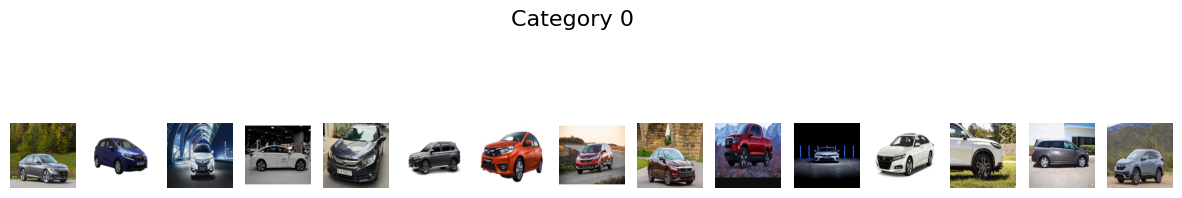

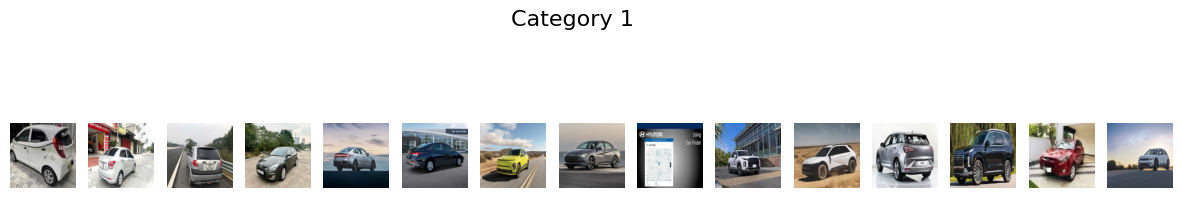

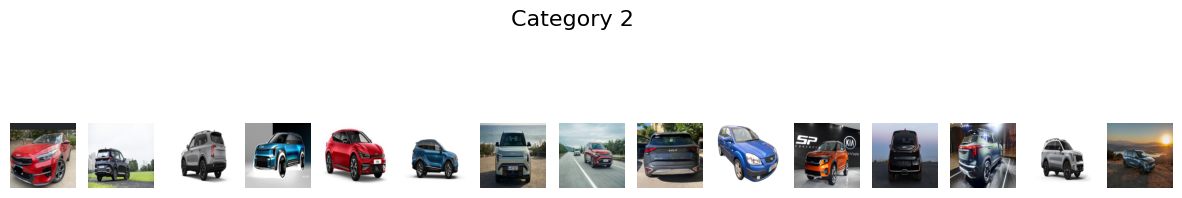

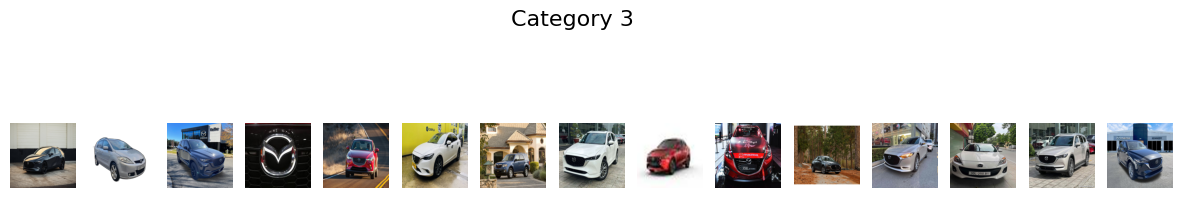

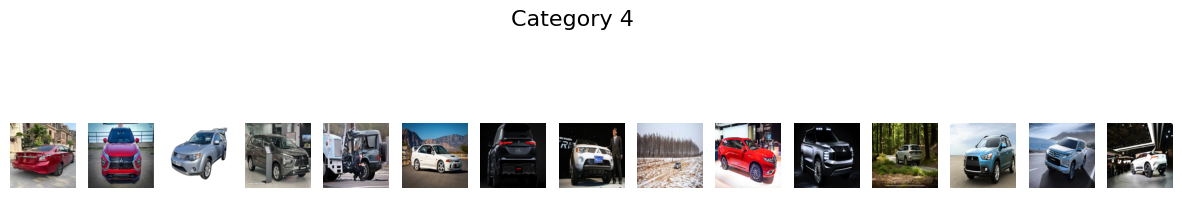

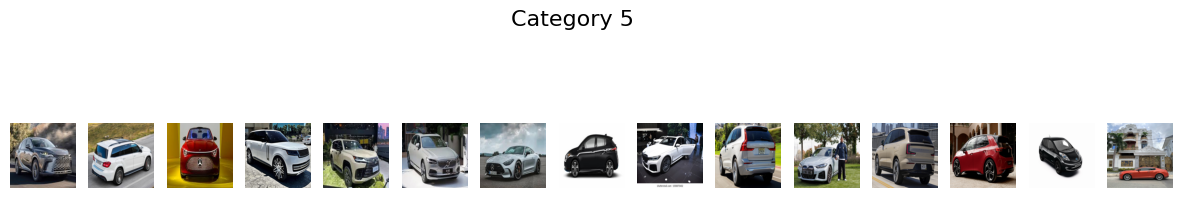

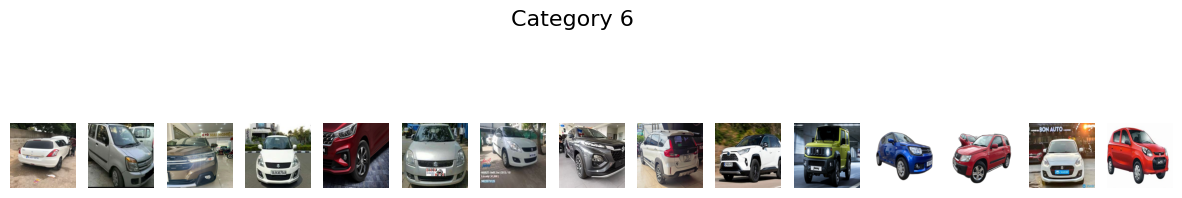

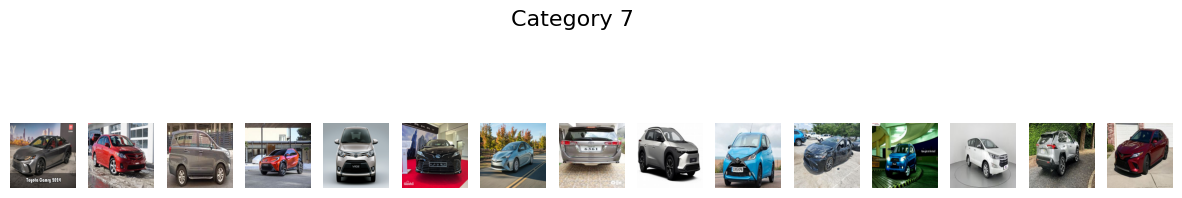

In [3]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Số ảnh hiển thị trên mỗi hàng
num_imgs_per_row = 15
img_size = 150  # Chiều cao và rộng của ảnh hiển thị

def display_samples(csv_file):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(csv_file)

    # Lấy danh sách các CategoryID
    categories = data['CategoryID'].unique()

    # Hiển thị ảnh mẫu cho từng CategoryID
    for category in categories:
        # Lấy đường dẫn ảnh ngẫu nhiên của category này
        samples = data[data['CategoryID'] == category].sample(num_imgs_per_row)
        img_paths = samples['ImageFullPath'].tolist()

        # Tạo một hàng hiển thị ảnh
        plt.figure(figsize=(15, 3))
        plt.suptitle(f'Category {category}', fontsize=16)

        for i, img_path in enumerate(img_paths):
            # Load ảnh và resize
            img = Image.open(os.path.join(base_folder, img_path))
            img = img.resize((img_size, img_size))

            # Hiển thị ảnh
            plt.subplot(1, num_imgs_per_row, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

# Hiển thị mẫu từ tập Train của Split 1
display_samples('MotocycleDataset-Splits-1-Train.csv')


In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf

# Tắt thông báo logging của TensorFlow (chỉ in lỗi)
tf.get_logger().setLevel('ERROR')

# Hàm trích xuất đặc trưng từ một ảnh
def extract_features(image_path, model, input_size=(224, 224)):
    try:
        img = load_img(image_path, target_size=input_size)  # Load ảnh và resize
        img_array = img_to_array(img)  # Chuyển ảnh thành array
        img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
        img_array = preprocess_input(img_array)  # Tiền xử lý cho MobileNet
        features = model.predict(img_array, verbose=0)  # Trích xuất đặc trưng (tắt thông báo)
        return features.flatten()  # Flatten thành vector 1D
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load MobileNet model (trích xuất đặc trưng từ layer cuối cùng)
mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')

# Đọc dữ liệu từ file CSV
csv_file = 'MotocycleDataset-Splits-1-Train.csv'
data = pd.read_csv(csv_file)

# Trích xuất đặc trưng cho từng ảnh
features = []
valid_paths = []  # Lưu các đường dẫn hợp lệ

# In thông báo bắt đầu
print("Bắt đầu trích xuất đặc trưng từ các ảnh...")

for idx, img_path in enumerate(data['ImageFullPath'], start=1):
    full_path = os.path.join(base_folder, img_path)  # Ghép base_folder với đường dẫn ảnh
    feature = extract_features(full_path, mobilenet_model)
    if feature is not None:
        features.append(feature)
        valid_paths.append(img_path)
    # In thông báo khi xử lý xong mỗi ảnh
    if idx % 1000 == 0:  # In thông báo sau mỗi 1000 ảnh
        print(f"Đang xử lý ảnh {idx}/{len(data)}...")

# Chuyển đổi đặc trưng thành numpy array
features = np.array(features)

# In thông báo khi hoàn thành
print(f"Trích xuất đặc trưng xong, số lượng ảnh hợp lệ: {features.shape[0]}")


<ipython-input-4-997c10472c42>:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Bắt đầu trích xuất đặc trưng từ các ảnh...
Error loading image /kaggle/input/dataset-car/Data/Honda/22521560-22521614.Honda.36.jpg: cannot identify image file <_io.BytesIO object at 0x7de11422a3e0>


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Đang xử lý ảnh 1000/26116...
Error loading image /kaggle/input/dataset-car/Data/Honda/22521560-22521614.Honda.37.jpg: cannot identify image file <_io.BytesIO object at 0x7de114594270>
Error loading image /kaggle/input/dataset-car/Data/Honda/22521560-22521614.Honda.41.jpg: cannot identify image file <_io.BytesIO object at 0x7de11431f1f0>
Đang xử lý ảnh 2000/26116...
Đang xử lý ảnh 3000/26116...
Đang xử lý ảnh 4000/26116...
Đang xử lý ảnh 5000/26116...
Đang xử lý ảnh 6000/26116...
Đang xử lý ảnh 7000/26116...
Đang xử lý ảnh 8000/26116...
Đang xử lý ảnh 9000/26116...
Đang xử lý ảnh 10000/26116...
Đang xử lý ảnh 11000/26116...
Error loading image /kaggle/input/dataset-car/Data/Mitsubishi/22521463-22521213-22521259.Mitsubishi.76.jpg: cannot identify image file <_io.BytesIO object at 0x7de0d090c0e0>
Error loading image /kaggle/input/dataset-car/Data/Mitsubishi/22521463-22521213-22521259.Mitsubishi.57.jpg: cannot identify image file <_io.BytesIO object at 0x7de0b02e44a0>
Đang xử lý ảnh 12000/

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Bước 1: Phân cụm các đặc trưng ảnh bằng K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# In kết quả phân cụm
print(f"Số lượng cluster: {len(set(cluster_labels))}")
print(f"Các cluster được phân bổ: {np.unique(cluster_labels, return_counts=True)}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Số lượng cluster: 5
Các cluster được phân bổ: (array([0, 1, 2, 3, 4], dtype=int32), array([4771, 4056, 4247, 6939, 6087]))


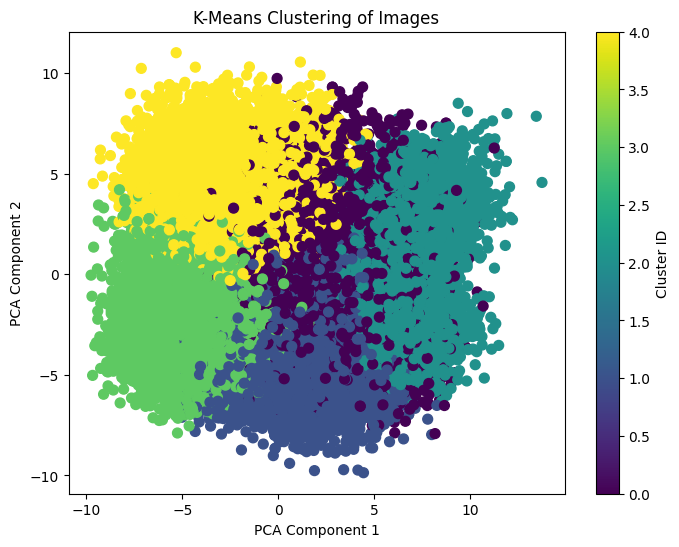

In [6]:
# Bước 2: Giảm chiều đặc trưng xuống 2 chiều bằng PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('K-Means Clustering of Images')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()


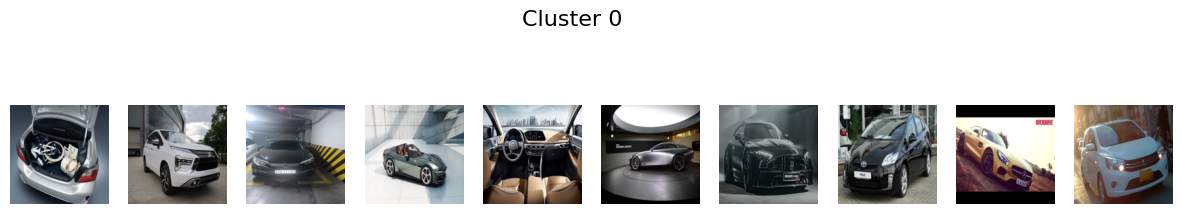

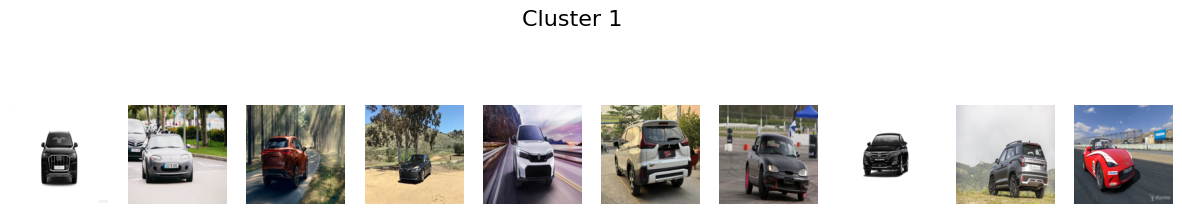

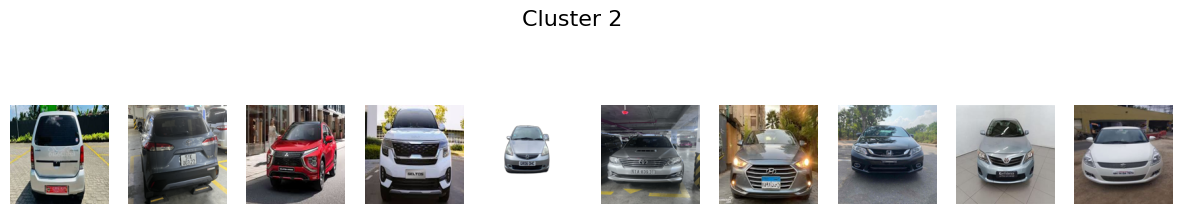

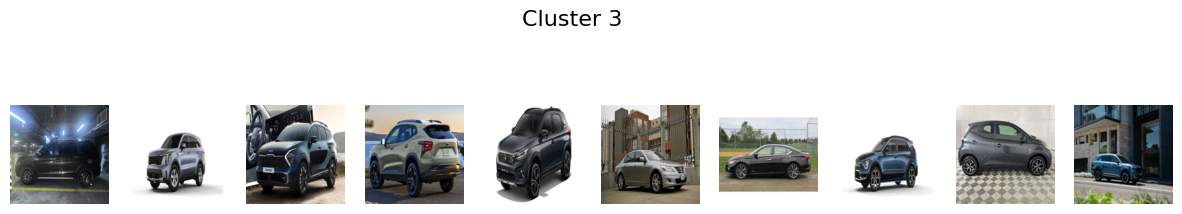

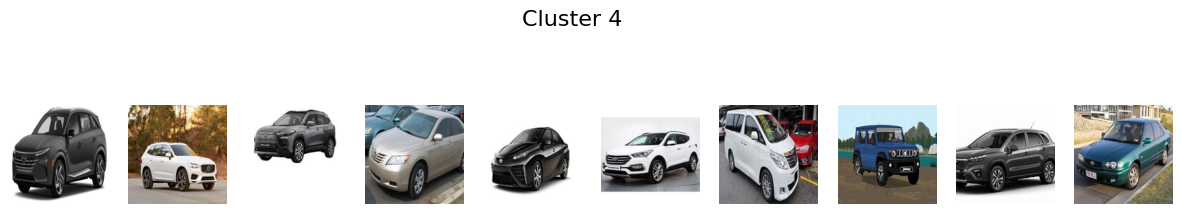

In [7]:
# Bước 3: Hiển thị các ảnh trong từng cluster
def display_cluster_images(cluster_labels, features, valid_paths, base_folder):
    num_clusters = len(set(cluster_labels))  # Số lượng cluster
    for cluster_id in range(num_clusters):
        # Lọc các ảnh trong cluster hiện tại
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_paths = np.array(valid_paths)[cluster_indices]
        
        # Lấy ngẫu nhiên 10 ảnh từ mỗi cluster
        sample_paths = np.random.choice(cluster_paths, 10, replace=False)
        
        # Hiển thị ảnh
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Cluster {cluster_id}", fontsize=16)
        
        for i, img_path in enumerate(sample_paths):
            img = Image.open(os.path.join(base_folder, img_path))
            img = img.resize((150, 150))  # Resize ảnh cho vừa màn hình
            plt.subplot(1, 10, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

# Gọi hàm để hiển thị ảnh từ các cluster
display_cluster_images(cluster_labels, features, valid_paths, base_folder)


In [8]:
from sklearn.metrics import silhouette_score

# Bước 4: Đánh giá kết quả phân cụm bằng Silhouette Score
silhouette_avg = silhouette_score(features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.020990636199712753


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def remove_duplicates(cluster_labels, features, valid_paths, threshold=0.9):
    unique_images = []
    unique_features = []
    unique_paths = []

    for cluster_id in set(cluster_labels):
        # Lọc ảnh trong cluster hiện tại
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_features = features[cluster_indices]
        cluster_paths = np.array(valid_paths)[cluster_indices]

        # Tính toán ma trận similarity giữa các ảnh trong cùng một cluster
        similarity_matrix = cosine_similarity(cluster_features)

        # Lọc ảnh trùng lặp (có similarity > threshold)
        for i in range(len(cluster_features)):
            is_duplicate = False
            for j in range(i+1, len(cluster_features)):
                if similarity_matrix[i, j] > threshold:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_images.append(cluster_features[i])
                unique_paths.append(cluster_paths[i])

    return np.array(unique_images), unique_paths

# Xử lý và loại bỏ ảnh trùng
unique_features, unique_paths = remove_duplicates(cluster_labels, features, valid_paths)
print(f"Sau khi loại bỏ trùng, số lượng ảnh còn lại: {len(unique_paths)}")


Sau khi loại bỏ trùng, số lượng ảnh còn lại: 24106


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Đọc lại dữ liệu gốc từ CSV để lấy CategoryID (hãng xe)
data = pd.read_csv(csv_file)

# Lấy nhãn (CategoryID) cho các ảnh còn lại (đã loại bỏ ảnh trùng)
remaining_labels = data[data['ImageFullPath'].isin(unique_paths)]['CategoryID']

# Chuẩn hóa dữ liệu (features)
scaler = StandardScaler()
unique_features_scaled = scaler.fit_transform(unique_features)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(unique_features_scaled, remaining_labels, test_size=0.2, random_state=42)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Khởi tạo mô hình Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Huấn luyện mô hình
logistic_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = logistic_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 57.55%
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       424
           1       0.57      0.52      0.54       562
           2       0.54      0.55      0.55       387
           3       0.41      0.41      0.41       487
           4       0.62      0.63      0.62       441
           5       0.49      0.47      0.48       657
           6       0.57      0.55      0.56       979
           7       0.76      0.79      0.77       885

    accuracy                           0.58      4822
   macro avg       0.56      0.56      0.56      4822
weighted avg       0.57      0.58      0.57      4822

